In [1]:
%matplotlib inline
%config InlineBackend.figure_format = True
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.utils.console import ProgressBar
import mrspoc 

from mrspoc import Star, Spot

spot_table = ascii.read('/Users/bmmorris/data/Mt_Wilson_Tilt/mwo_spot_table.txt').group_by('jd')
spot_table.add_index('jd')

Example, demo of API:

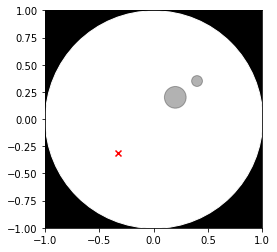

In [2]:
s = Star()

spot_list = [Spot(x=0.2, y=0.20, r=0.10),
             Spot(x=0.4, y=0.35, r=0.05)]

s.spots.extend(spot_list)

ax = s.plot(col_exaggerate=50)

For all dates in the MWO spot catalog, compute the solar photocenter. 

In [3]:
dates = sorted(list(set(spot_table['jd'])))
center_of_light = []

scale_up_umbra = 5

with ProgressBar(len(dates), ipython_widget=True) as bar:
    for date in dates:    
        sun = Star()
        spots_today = spot_table[spot_table['jd'] == date]

        for spot in spots_today:
            lon = spot['area_weighted_longitude_day_1']
            lat = spot['area_weighted_latitude_day_1']
            areas = spot['area_day_1']
            rspot_rstar = np.sqrt(1e-6 * 2 * (scale_up_umbra * areas))
            new_spot = Spot.from_latlon(lat, lon, rspot_rstar)
            sun.spots.append(new_spot)

        center_of_light.append(sun.center_of_light)
        bar.update()

center_of_light = np.array(center_of_light)
#     sun.plot()
#     plt.show()

In [4]:
#plt.scatter(center_of_light[:, 0], center_of_light[:, 1], marker='.', s=2, c=dates)

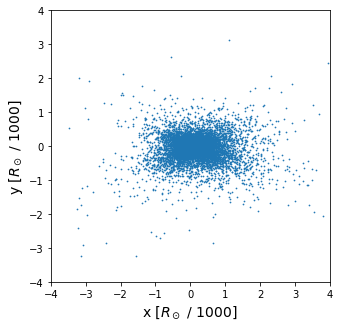

In [5]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(center_of_light[:, 0] * 1000, center_of_light[:, 1] * 1000, marker='.', s=2)
ax.set_xlabel('x [$R_\odot$ / 1000]', fontsize=14)
ax.set_ylabel('y [$R_\odot$ / 1000]', fontsize=14)
ax.set(xlim=[-4, 4], ylim=[-4, 4])
fig.savefig('plots/photocenter_motion.pdf', bbox_inches='tight')

What is the meadian absolute deviation of the solar photocenter over the entire MWO sample?

In [6]:
from astropy.stats import mad_std

mad = lambda x: mad_std(x)/1.4826

mad_x = mad(center_of_light[:, 0])
mad_y = mad(center_of_light[:, 1])

print("MAD x = {0}\nMAD y = {1}".format(mad_x, mad_y))

MAD x = 0.00022130824778557938
MAD y = 0.00012676118410517447


What was the maximum number of spots on the sun on a single day?

max spots 14


(array([ 4801.,  1806.,  1328.,  1773.,   445.,   300.,   273.,    61.,
           21.,    10.]),
 array([  1. ,   2.3,   3.6,   4.9,   6.2,   7.5,   8.8,  10.1,  11.4,
         12.7,  14. ]),
 <a list of 10 Patch objects>)

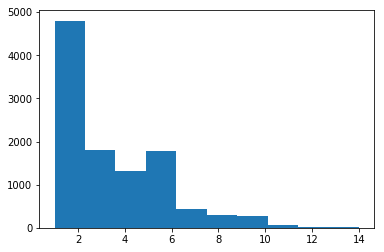

In [7]:
nspots = np.array([len(spot_table[spot_table['jd'] == date]) for date in dates])
print('max spots', np.max(nspots))
plt.hist(nspots)

Compute the sizes 

In [8]:
spot_radii = np.sqrt(1e-6 * 10 * spot_table['area_day_1'])

Compute some basic stats on spot radii, number of spots on a typical day: 

In [9]:
np.median(spot_radii), np.mean(nspots), np.median(nspots)

(0.010831897340724754, 3.3606026992050286, 3.0)

Compute the displacement vector of the solar photocenter from the true solar centroid at each time.

(0.0, 0.005)

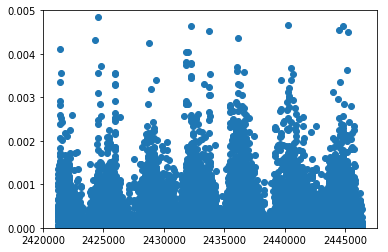

In [10]:
r_vector = np.sqrt(center_of_light[:, 0]**2 + center_of_light[:, 1]**2)
plt.scatter(dates, r_vector)
plt.ylim([0.0, 0.005])

1917-02-09 06:59:00.000


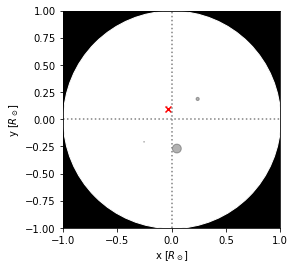

In [11]:
from astropy.time import Time

date = dates[20]

s = Star()
spots_today = spot_table[spot_table['jd'] == date]

for spot in spots_today:
    lon = spot['area_weighted_longitude_day_1']
    lat = spot['area_weighted_latitude_day_1']
    areas = spot['area_day_1']
    rspot_rstar = np.sqrt(1e-6 * 2 * (scale_up_umbra * areas))
    new_spot = Spot.from_latlon(lat, lon, rspot_rstar)
    s.spots.append(new_spot)

print(Time(date, format='jd').iso)
ax = s.plot(col_exaggerate=100)
ax.axhline(0, ls=':', color='gray')
ax.axvline(0, ls=':', color='gray')
ax.set(xlabel='x [$R_\odot$]', ylabel='y [$R_\odot$]')
fig.savefig('plots/example_sun.pdf', bbox_inches='tight')

1959-05-10 09:48:00.000


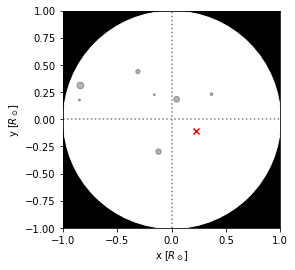

In [12]:
#date = dates[-6000]
date = dates[-4110]

fig, ax = plt.subplots()
s = Star()
spots_today = spot_table[spot_table['jd'] == date]

for spot in spots_today:
    lon = spot['area_weighted_longitude_day_1']
    lat = spot['area_weighted_latitude_day_1']
    areas = spot['area_day_1']
    rspot_rstar = np.sqrt(1e-6 * 2 * (scale_up_umbra * areas))
    new_spot = Spot.from_latlon(lat, lon, rspot_rstar)
    s.spots.append(new_spot)

print(Time(date, format='jd').iso)
ax = s.plot(col_exaggerate=100, ax=ax)
ax.axhline(0, ls=':', color='gray')
ax.axvline(0, ls=':', color='gray')
ax.set(xlabel='x [$R_\odot$]', ylabel='y [$R_\odot$]')
fig.savefig('plots/example_sun.pdf', bbox_inches='tight')

In [13]:
from astropy.constants import R_sun, M_sun, R_jup, M_jup, R_earth, M_earth, G
import astropy.units as u

a_jup = 5.2 * u.AU
a_earth = 1.0 * u.AU
p_jup = 11.8 * u.year
p_earth = 1 * u.year

# Solve for reflex motion radius

reflex_jup = ((a_jup * M_jup / M_sun)).decompose() / R_sun
reflex_earth = ((a_earth * M_earth / M_sun)).decompose() / R_sun

print(reflex_jup, reflex_earth)

1.0673959707897154 0.0006458467892169156


In [14]:
distance = 1 * u.pc
np.arctan(((reflex_jup*R_sun)/distance).decompose()).to(u.uarcsec)

<Quantity 4963.890016679382 uarcsec>

2.45813601141 uas
earth 3.0034893488743255
0.491627202281 uas
earth 0.6006978697748651
0.245813601141 uas
earth 0.30034893488743253


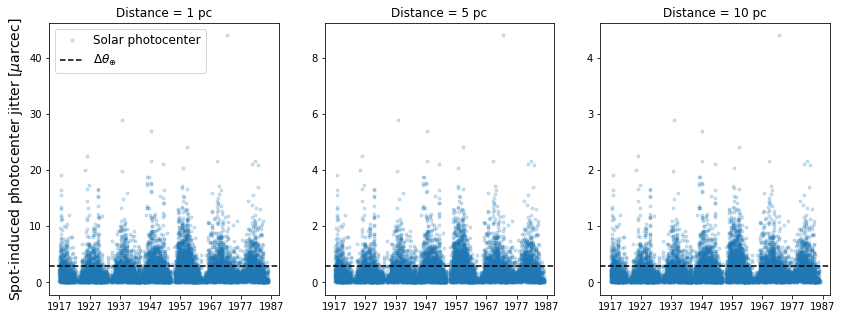

In [15]:
# Position jitter at D parsecs

from astropy.constants import R_sun
import astropy.units as u

distances = np.array([1, 5, 10])*u.pc
dates_plot = Time(dates, format='jd').plot_date

fig, ax = plt.subplots(1, len(distances), figsize=(14, 5))
for i, distance in enumerate(distances):
    angle = np.arctan(((r_vector*R_sun)/distance).decompose())

    print(np.std(angle.to(u.uarcsec).value), 'uas')
    
    earth_angle = np.arctan(((reflex_earth*R_sun)/distance).decompose())
    print('earth', earth_angle.to(u.uarcsec).value)
    ax[i].plot_date(dates_plot, angle.to(u.uarcsec), '.', alpha=0.2, 
                    label='Solar photocenter')
    ax[i].set_title('Distance = {0:d} pc'.format(int(distance.value)))
    ax[i].axhline(+earth_angle.to(u.uarcsec).value, ls='--', color='k', 
                  label=r"$\Delta \theta_{\oplus}$")

ax[0].legend(fontsize=12)
ax[0].set_ylabel('Spot-induced photocenter jitter [$\mu$arcec]', fontsize=14)
fig.savefig('plots/jitter.pdf', bbox_inches='tight', dpi=150)

On what day was the sunspot distribution most asymmetric? Plot a diagram of the sun on that day below. 

In [16]:
Time(dates[np.argmax(r_vector)], format='jd').iso

'1972-06-07 14:44:00.000'

0.000310520740615 0.00945570823652
1972-06-07 14:44:00.000


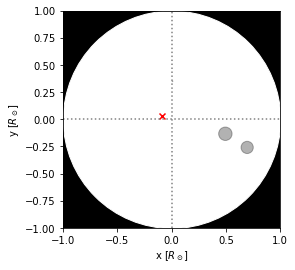

In [17]:
print(np.median(r_vector), np.max(r_vector))

date = dates[np.argmax(r_vector)]
fig, ax = plt.subplots()
s = Star()
spots_today = spot_table[spot_table['jd'] == date]

for spot in spots_today:
    lon = spot['area_weighted_longitude_day_1']
    lat = spot['area_weighted_latitude_day_1']
    areas = spot['area_day_1']
    rspot_rstar = np.sqrt(1e-6 * 2 * (scale_up_umbra * areas))
    new_spot = Spot.from_latlon(lat, lon, rspot_rstar)
    s.spots.append(new_spot)

print(Time(date, format='jd').iso)
ax = s.plot(col_exaggerate=10, ax=ax)
ax.axhline(0, ls=':', color='gray')
ax.axvline(0, ls=':', color='gray')
ax.set(xlabel='x [$R_\odot$]', ylabel='y [$R_\odot$]')
fig.savefig('plots/example_sun.pdf', bbox_inches='tight')

*** 

## Gaia noise model

Simple Gaia noise model of Perryman et al. 2014:

$$ \sigma_{fov} = \sqrt{ \sigma_\eta^2/9 + \sigma_{att}^2 + \sigma_{cal}^2} $$

where $\sigma_{att} \approx \sigma_{cal} = 20 \mu$as, and

$$ \sigma_\eta = \sqrt{53000 z + 310 z^2} $$

for 

$$ z = 10^{0.4\left(\max[G, 12] - 15\right)}$$

Which stars have astrometric errors in DR1 smaller than the estimated jitter due to solar-like activity cycles?

In [18]:
from mrspoc import get_table_ms

/Users/bmmorris/git/mrspoc/mrspoc/tgas.py:83: RuntimeWarning: invalid value encountered in log10
  M_V = Vmag - 5*(np.log10(dist_pc) + 1)
/Users/bmmorris/git/mrspoc/mrspoc/tgas.py:140: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(H.T), extent=extent, cmap=plt.cm.Greys, aspect=0.2)


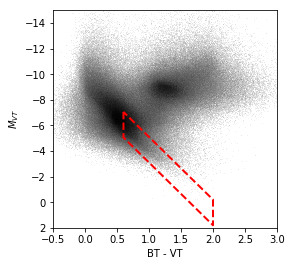

In [19]:
table = get_table_ms()

In [26]:
# Compute the apparent angular jitter due to sunspots at the
# distances of nearby MS stars in the TGAS sample
distances = table['distance'].quantity
#R_star = bv_to_radius(table['B-V'].data.data)
R_star = table['R_star'].quantity
jitter_rstar =  np.std(r_vector) * R_star
sigma_jitter = np.arctan((jitter_rstar/distances).decompose()).to(u.uarcsec)

# Estimate the single-measurement astrometric error for each star
# in the TGAS sample: 
sigma_gaia = table['sigma_fov']/np.sqrt(table['N_fov'])

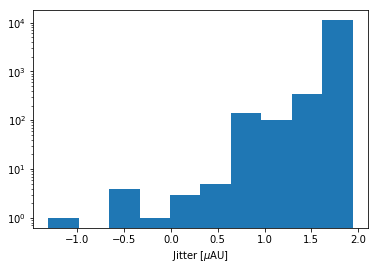

In [54]:
plt.hist(jitter_rstar.to(u.uAU), log=True)
plt.xlabel('Jitter [$\mu$AU]')

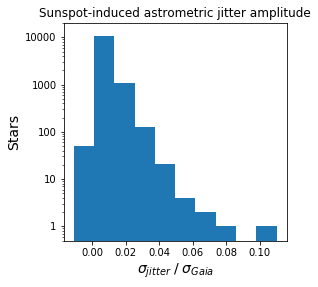

In [29]:
#plt.hist(jitter_amplitude, log=True);
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(sigma_jitter/sigma_gaia, log=True, histtype='stepfilled')
ax.set_title('Sunspot-induced astrometric jitter amplitude')
ax.set_xlabel('$\sigma_{jitter} \; / \; \sigma_{Gaia}$', fontsize=14)
ax.set_ylabel('Stars', fontsize=14)
ax.set_ylim([0.5, 2e4])

y = [1, 10, 100, 1000, 1e4]
ax.set_yticks(y)
ax.set_yticklabels(["{0:g}".format(i) for i in y])

fig.savefig('plots/sunspot_jitter.pdf', bbox_inches='tight')

### Activity Cycle

In [33]:
from astropy.table import Column

table.add_column(Column(data=sigma_jitter, name='sigma_jitter'))
table.add_column(Column(data=sigma_gaia, name='sigma_gaia'))
table.add_column(Column(data=(sigma_jitter/sigma_gaia).decompose(), name='snr'))

In [42]:
snr_gtr20 = table[table['snr'] > 0.04]
print("N stars:", np.count_nonzero(snr_gtr20))

from astroquery.simbad import Simbad

sp_types = []
main_id = []
for hip_number in snr_gtr20['HIP']:
    customSimbad = Simbad()
    customSimbad.add_votable_fields('sptype')
    query = customSimbad.query_object("HIP {0}".format(hip_number))
    sp_types.append(query['SP_TYPE'][0])
    main_id.append(query['MAIN_ID'][0])

sptype_colname = 'Sp Type'
mainid_colname = 'main_id'

if not sptype_colname in snr_gtr20.colnames:
    snr_gtr20.add_column(Column(data=sp_types, name=sptype_colname))

if not mainid_colname in snr_gtr20.colnames:
    snr_gtr20.add_column(Column(data=main_id, name=mainid_colname))

N stars: 23


In [43]:
from scipy.stats import anderson_ksamp, ks_2samp
from astropy.utils.console import ProgressBar

n_realizations = 1000

anderson_matrix = np.zeros((len(snr_gtr20), n_realizations))
ks_matrix = np.zeros((len(snr_gtr20), n_realizations))

with ProgressBar(n_realizations, ipython_widget=True) as bar:
    for i in range(n_realizations):
        # Observe the star N_fov times at minimum
        activity_minimum = [np.random.normal(loc=0, scale=sigma_fov, size=N_fov) 
                             for sigma_fov, N_fov in 
                             zip(snr_gtr20['sigma_fov'].to(u.uarcsec).value, 
                                 snr_gtr20['N_fov'])]

        # Observe the star N_fov times at maximum
        activity_maximum = [np.random.normal(loc=0, scale=np.sqrt(sigma_fov**2 + sigma_jitter**2), size=N_fov) 
                            for sigma_fov, sigma_jitter, N_fov in 
                            zip(snr_gtr20['sigma_fov'].to(u.uarcsec).value, 
                                snr_gtr20['sigma_jitter'], 
                                snr_gtr20['N_fov'])]

        # Compute the significance between position distributions activity minimum and maximum
        anderson = np.array([anderson_ksamp([minimum, maximum]).significance_level 
                             for minimum, maximum in zip(activity_minimum, activity_maximum)])
        ks = np.array([ks_2samp(minimum, maximum).pvalue
                       for minimum, maximum in zip(activity_minimum, activity_maximum)])

        anderson_matrix[:, i] = anderson
        ks_matrix[:, i] = ks
        bar.update()

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/stats/morestats.py:1694: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


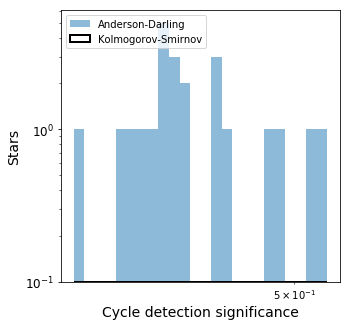

In [44]:
nbins = 25
log = True

fig, ax = plt.subplots(figsize=(5, 5))
MIN = anderson_matrix.mean(1).min()
MAX = anderson_matrix.mean(1).max()
bins = 10 ** np.linspace(np.log10(MIN), np.log10(MAX), nbins)
ax.hist(anderson_matrix.mean(1), bins=bins, log=log, 
        label='Anderson-Darling', alpha=0.5, histtype='stepfilled')
ax.hist(ks_matrix.mean(1), bins=bins, histtype='step', 
        color='k', lw=2, log=log, label='Kolmogorov-Smirnov')
ax.set_xscale("log")
ax.legend(loc='upper left')
ax.set_xlabel('Cycle detection significance', fontsize=14)
ax.set_ylabel('Stars', fontsize=14)
# ax.set_yticks([1, 10, 100])
# ax.set_yticklabels([1, 10, 100])

plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)

# ax.set_ylim([0.8, 100])
fig.savefig('plots/solar_cycle.pdf', bbox_inches='tight')

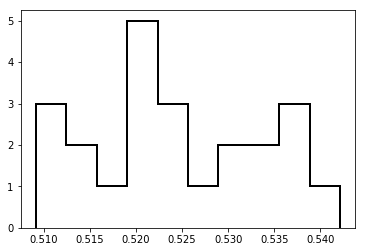

In [46]:
plt.hist(ks_matrix.mean(1), bins=10, histtype='step', 
        color='k', lw=2, label='Kolmogorov-Smirnov');

In [50]:
s = '\n'.join(["\object{{{0}}}".format(i) for i in "AX Mic, HD  79211, $\sigma$ Dra, GX And, HD 222237, G 202-48, LHS 3531, SZ UMa, HD 216899, HD 36395, HD 42581".split(', ')])
print(s)

\object{AX Mic}
\object{HD  79211}
\object{$\sigma$ Dra}
\object{GX And}
\object{HD 222237}
\object{G 202-48}
\object{LHS 3531}
\object{SZ UMa}
\object{HD 216899}
\object{HD 36395}
\object{HD 42581}
